In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib ipympl

In [2]:
ground = {
    "a": 0, 
    "b": 119,
    "c": 209
}
excited = {
    "c": 0,
    "b": 191,
    "a": 451
}
for kk in ground:
    ground[kk] -= int(np.average(list(ground.values())))
for kk in excited:
    excited[kk] -= int(np.average(list(excited.values())))

In [69]:
def optical_pump(pops, frequency):
    for gg in ground:
        for ee in excited:
            spec_class = frequency - (excited[ee] - ground[gg])
            pop = pops[gg][spec_class] + pops[gg + "bar"][spec_class]
            pops[gg][spec_class] = 0
            pops[gg + "bar"][spec_class] = 0
            for gg1 in ground:
                if gg1 != gg and gg1 != gg + "bar":
                    pops[gg1][spec_class] += pop / 4
                    pops[gg1 + "bar"][spec_class] += pop / 4

In [190]:
def rf_repop(pops, state1, state2):
    for kk in freqs:
        total_pop = pops[state1][kk] + pops[state2][kk]
        for gg in [state1, state2]:
            pops[gg][kk] = total_pop / 2

In [191]:
def reset(pops):
    for kk in ["a", "abar", "b", "bbar", "c", "cbar"]:
        pops[kk] = {}
        for ll in freqs:
            pops[kk][ll] = 1 / 6

In [192]:
def absorption(pops, frequency, transitions=None):
    pop = 0
    for gg in ground:
        for ee in excited:
            if transitions is not None and gg + ee not in transitions:
                continue
            spec_class = frequency - (excited[ee] - ground[gg])
            pop += pops[gg][spec_class] + pops[gg + "bar"][spec_class]
    return pop

In [193]:
inhom_width = 2000
freqs = list(range(-inhom_width, inhom_width))
pops = {}
for kk in ["a", "abar", "b", "bbar", "c", "cbar"]:
    pops[kk] = {}
    for ll in freqs:
        pops[kk][ll] = 1 / 6

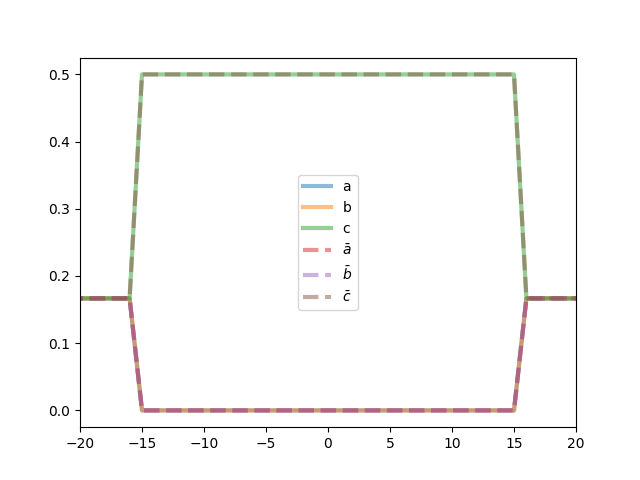

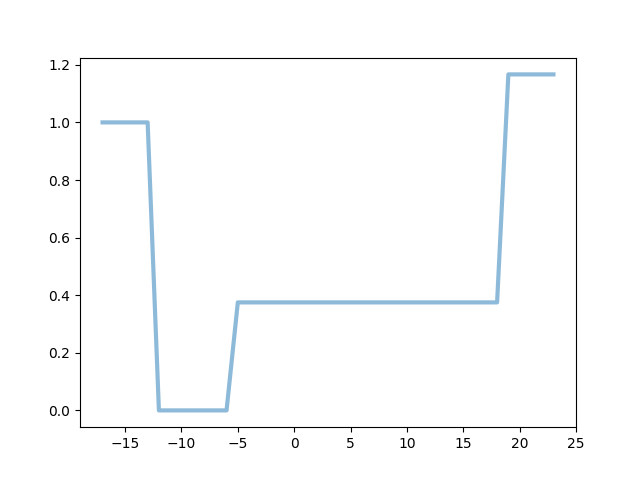

In [230]:
reset(pops)
freq_bb = excited["b"] - ground["b"]
freq_ac = excited["c"] - ground["a"]
freq_ca = excited["a"] - ground["c"]

for ll in range(100):
    # for kk in range(freq_ac - 5, freq_ac + 6):
    #   optical_pump(pops, kk)
    # for kk in range(freq_ca - 5, freq_ca + 6):
    #   optical_pump(pops, kk)
    for kk in range(freq_bb - 15, freq_bb + 16):
        optical_pump(pops, kk)
    rf_repop(pops, "a", "b")
    rf_repop(pops, "abar", "bbar")
# for ll in range(100):
#     rf_repop(pops, "abar", "bbar")
#     optical_pump(pops, freq_ac)
#     optical_pump(pops, freq_ca)
# rf_repop(pops, "abar", "bbar")

fig, ax = plt.subplots()
ax.plot(freqs, [pops["a"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="a")
ax.plot(freqs, [pops["b"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="b")
ax.plot(freqs, [pops["c"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="c")
ax.plot(freqs, [pops["abar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{a}$", ls="--")
ax.plot(freqs, [pops["bbar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{b}$", ls="--")
ax.plot(freqs, [pops["cbar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{c}$", ls="--")
ax.set_xlim(-20, 20)
ax.legend()
plt.show()

probe_freqs = list(range(freq_bb - 20, freq_bb + 21))
transitions = ["bb", "ac", "ca"]
#transitions = ["bb"]
fig, ax = plt.subplots()
ax.plot(probe_freqs, [absorption(pops, kk, transitions) for kk in probe_freqs], linewidth=3, alpha=0.5)
plt.show()